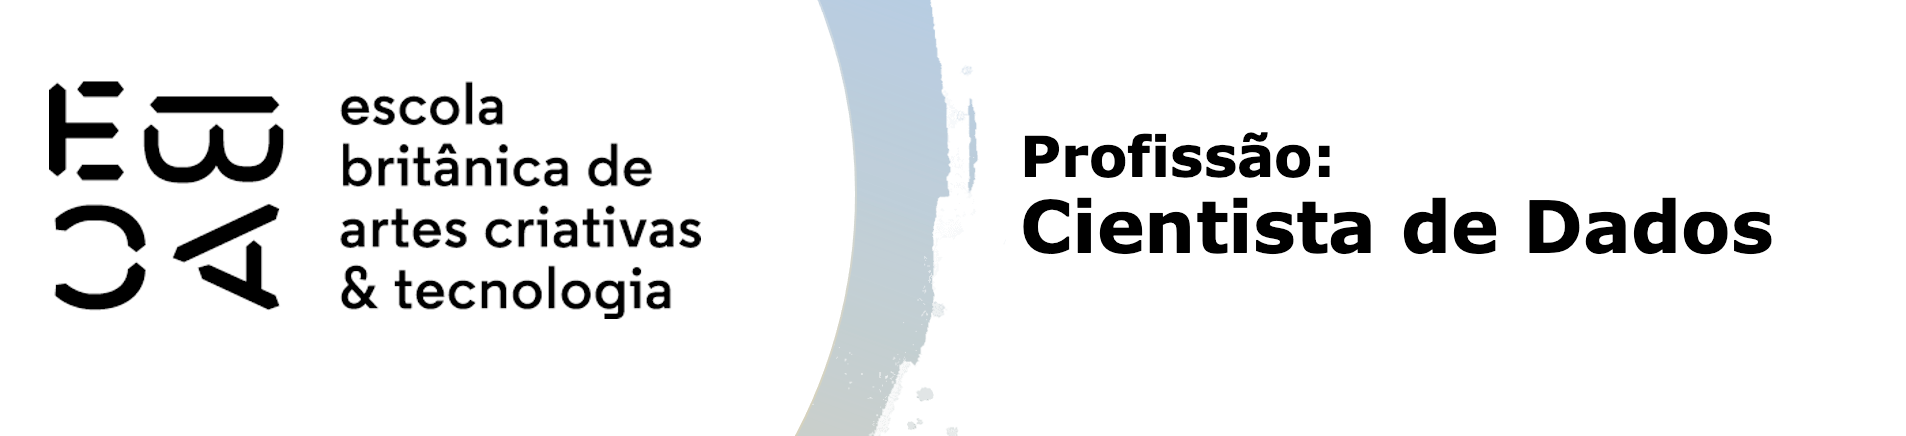

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import t


df = pd.read_feather('./credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [3]:
df.tempo_emprego = df.tempo_emprego.fillna(df.tempo_emprego.mean())

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
df_ = df[df.data_ref < '2016-01-01'].copy()
smpl_oot = df[df.data_ref >= '2016-01-01'].copy()

print(f'Linhas e colunas população : {df_.shape}\nLinhas e colunas amostra : {smpl_oot.shape}')


Linhas e colunas população : (600000, 15)
Linhas e colunas amostra : (150000, 15)


In [5]:
tab_pop = df_.mau.value_counts()
tab_pop


False    563357
True      36643
Name: mau, dtype: int64

In [6]:
tab_smpl = smpl_oot.mau.value_counts()
tab_smpl


False    128000
True      22000
Name: mau, dtype: int64

In [12]:
rho_mau = tab_smpl[1]/tab_smpl.sum()
rho_bom = tab_smpl[0]/tab_smpl.sum()

pi_mau = tab_pop[1]/tab_pop.sum()
pi_bom = tab_pop[0]/tab_pop.sum()

wbom = pi_bom*rho_bom
wmau = pi_mau*rho_mau

print(f'wbom= {wbom}, wmau={wmau}')

smpl_oot.loc[smpl_oot.mau == 1,'w']=wmau
smpl_oot.loc[smpl_oot.mau == 0,'w']=wbom

smpl_oot.groupby('mau')[['w']].sum()/smpl_oot.w.sum()

wbom= 0.8012188444444446, wmau=0.008957177777777778


,w
mau,
False,0.998082
True,0.001918


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [13]:
df_mes = df.groupby('data_ref')['mau'].sum()
df_mes = pd.concat([df_mes,df.groupby('data_ref')['data_ref'].count()],axis=1)
df_mes['ratio'] = df_mes.mau / df_mes.data_ref * 100
df_mes


,mau,data_ref,ratio
data_ref,,,
2015-01-01,6057,50000,12.114
2015-02-01,4934,50000,9.868
2015-03-01,3678,50000,7.356
2015-04-01,2663,50000,5.326
2015-05-01,1851,50000,3.702
2015-06-01,1513,50000,3.026
2015-07-01,1361,50000,2.722
2015-08-01,1477,50000,2.954
2015-09-01,1902,50000,3.804


In [19]:
df_.sexo.value_counts()

F    403805
M    196195
Name: sexo, dtype: int64

In [20]:
df_.posse_de_veiculo.value_counts()

N    366293
S    233707
Name: posse_de_veiculo, dtype: int64

In [21]:
df_.posse_de_imovel.value_counts()

S    403054
N    196946
Name: posse_de_imovel, dtype: int64

In [22]:
df_.qtd_filhos.value_counts()

0     413882
1     122471
2      55603
3       6960
4        854
7         82
5         77
14        71
Name: qtd_filhos, dtype: int64

In [23]:
df_.tipo_renda.value_counts()

Assalariado         308460
Empresário          138141
Pensionista         101127
Servidor público     51981
Bolsista               291
Name: tipo_renda, dtype: int64

In [24]:
df_.educacao.value_counts()

Médio                  405449
Superior completo      163440
Superior incompleto     23559
Fundamental              6901
Pós graduação             651
Name: educacao, dtype: int64

In [25]:
df_.estado_civil.value_counts()

Casado      421149
Solteiro     73221
União        46108
Separado     34188
Viúvo        25334
Name: estado_civil, dtype: int64

In [26]:
df_.tipo_residencia.value_counts()

Casa             539336
Com os pais       26730
Governamental     18742
Aluguel            8262
Estúdio            4296
Comunitário        2634
Name: tipo_residencia, dtype: int64

In [45]:
var = df_.idade
cat_srs = pd.qcut(var, 5, precision=0, duplicates='drop')

cat_srs.value_counts().sort_index()

(21.0, 33.0]    135135
(33.0, 40.0]    123702
(40.0, 47.0]    114926
(47.0, 55.0]    109960
(55.0, 68.0]    116277
Name: idade, dtype: int64

In [42]:
var = df_.tempo_emprego
cat_srs = pd.qcut(var, 5, precision=2, duplicates='drop')

cat_srs.value_counts().sort_index()



(0.11, 2.91]      120028
(2.91, 5.76]      119974
(5.76, 7.75]      169597
(7.75, 10.44]      70466
(10.44, 42.91]    119935
Name: tempo_emprego, dtype: int64

In [29]:
df_.qt_pessoas_residencia.value_counts()

2.0     326181
1.0     108657
3.0     104126
4.0      53314
5.0       6638
6.0        890
9.0         82
15.0        71
7.0         41
Name: qt_pessoas_residencia, dtype: int64

In [43]:
var = df_.renda
cat_srs = pd.qcut(var, 5, precision=0, duplicates='drop')

cat_srs.value_counts().sort_index()


(161.0, 3905.0]         120003
(3905.0, 7431.0]        119998
(7431.0, 13152.0]       120004
(13152.0, 26667.0]      120000
(26667.0, 4083986.0]    119995
Name: renda, dtype: int64

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [14]:
def bi_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)
        

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv.index, biv.woe, ':bo', label='woe')
    ax[0].plot(biv.index, biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv.index, biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    
    return biv

In [15]:
def bi_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)
        

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    
    return biv

,qt_bom,qt_mau,mau,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,
F,378318,25487,0.063117,403805,0.000383,0.063867,0.062367,-2.697567,-2.684953,-2.710321,0.035125,0.047739,0.02237
M,185039,11156,0.056862,196195,0.000523,0.057887,0.055837,-2.808589,-2.789641,-2.827861,-0.075898,-0.056950,-0.09517


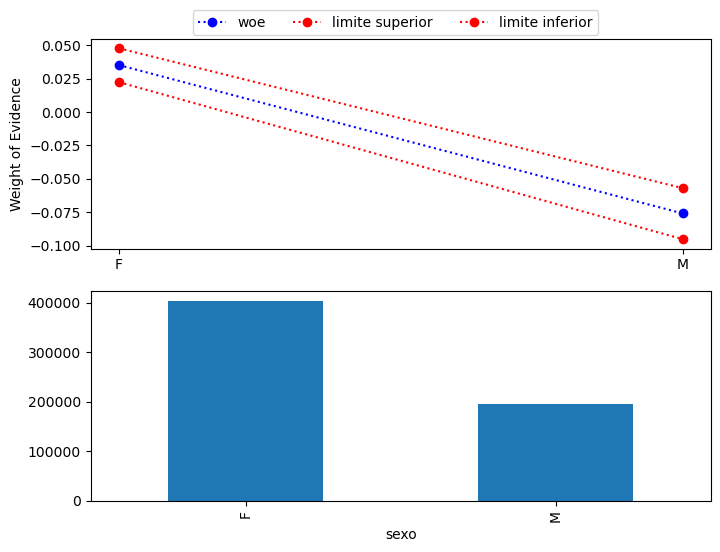

In [16]:
bi_discreta('sexo',df_)

,qt_bom,qt_mau,mau,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,
N,343778,22515,0.061467,366293,0.000397,0.062245,0.060689,-2.725814,-2.712410,-2.739378,0.006877,0.020281,-0.006687
S,219579,14128,0.060452,233707,0.000493,0.061418,0.059486,-2.743553,-2.726667,-2.760694,-0.010862,0.006024,-0.028003


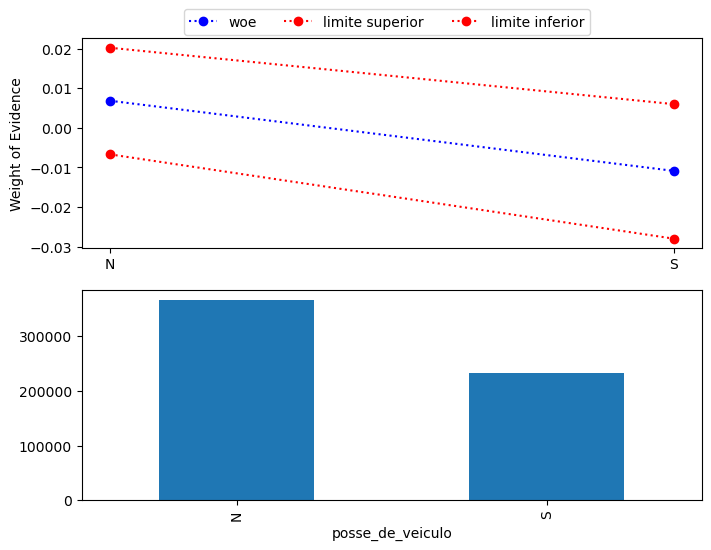

In [17]:
bi_discreta('posse_de_veiculo',df_)

,qt_bom,qt_mau,mau,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,
N,183305,13641,0.069263,196946,0.000572,0.070384,0.068141,-2.598071,-2.580806,-2.615598,0.134620,0.151885,0.117093
S,380052,23002,0.057069,403054,0.000365,0.057785,0.056353,-2.804727,-2.791496,-2.818114,-0.072036,-0.058805,-0.085423


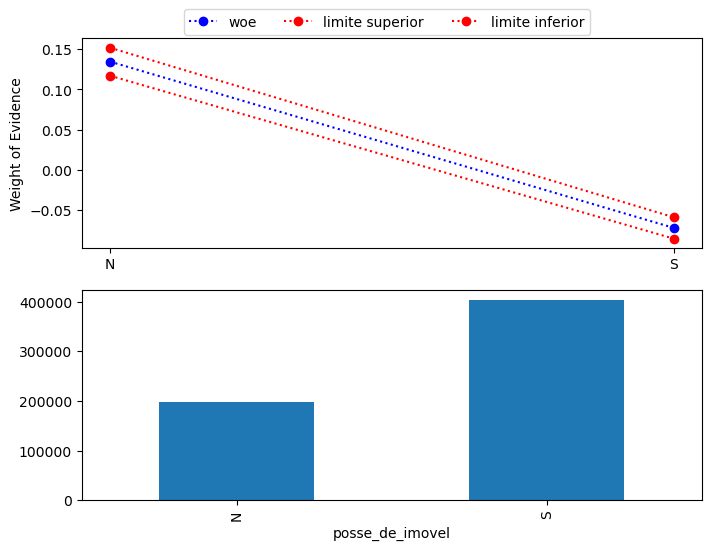

In [172]:
bi_discreta('posse_de_imovel',df_)

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
"(-1.0, 1.0]",503676,32677,0.060924,0.228340,536353,0.000327,0.061565,0.060284,-2.735262,-2.724128,-2.746506,-0.002571,0.008563,-0.013815
"(1.0, 14.0]",59681,3966,0.062312,2.159646,63647,0.000958,0.064190,0.060434,-2.711256,-2.679559,-2.743858,0.021435,0.053133,-0.011166


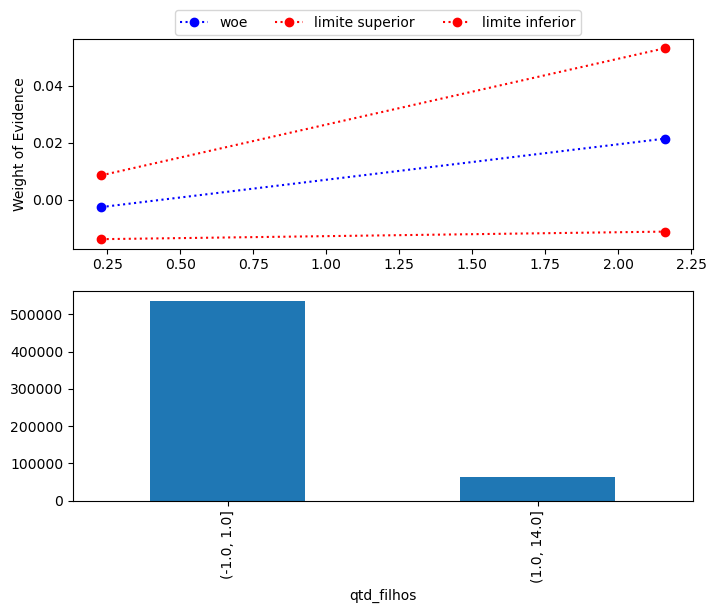

In [173]:
bi_continua('qtd_filhos',4,df_)

,qt_bom,qt_mau,mau,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Bolsista,279,12,0.041237,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.413614,0.052933,-1.249925
Empresário,129935,8206,0.059403,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,49651,2330,0.044824,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


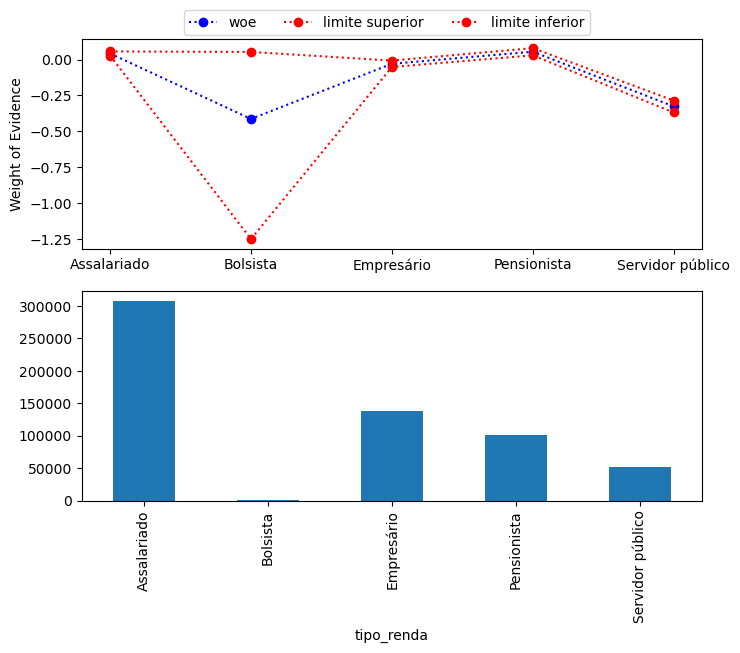

In [174]:
bi_discreta('tipo_renda',df_)

,qt_bom,qt_mau,mau,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,
Assalariado/Bolsista,289144,19607,0.063504,308751,0.000439,0.064364,0.062644,-2.691038,-2.676665,-2.705594,0.041653,0.056027,0.027097
Empresário,129935,8206,0.059403,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,49651,2330,0.044824,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


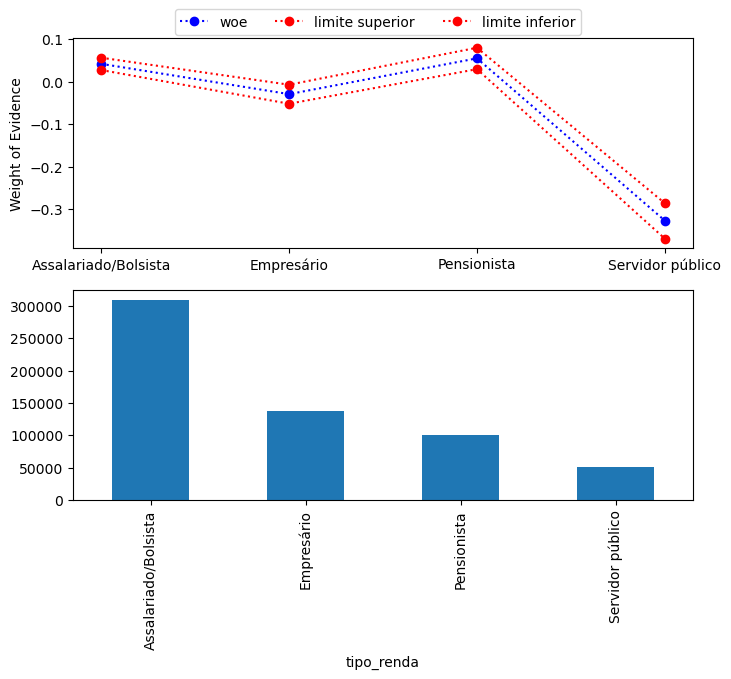

In [176]:
df_['tipo_renda'] = df_['tipo_renda'].replace({'Assalariado':'Assalariado/Bolsista', 'Bolsista':'Assalariado/Bolsista'})
bi_discreta('tipo_renda',df_)

,qt_bom,qt_mau,mau,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,
Fundamental,7789,786,0.091662,8575,0.003116,0.097770,0.085554,-2.293511,-2.222252,-2.369175,0.173677,0.244936,0.098013
Médio,466106,40730,0.080361,506836,0.000382,0.081110,0.079613,-2.437448,-2.427364,-2.447619,0.029740,0.039824,0.019570
Pós graduação,753,59,0.072660,812,0.009109,0.090541,0.054779,-2.546528,-2.307049,-2.848105,-0.079340,0.160139,-0.380917
Superior completo,189684,14622,0.071569,204306,0.000570,0.072687,0.070451,-2.562832,-2.546130,-2.579777,-0.095644,-0.078942,-0.112588
Superior incompleto,27025,2446,0.082997,29471,0.001607,0.086147,0.079847,-2.402308,-2.361619,-2.444427,0.064880,0.105569,0.022761


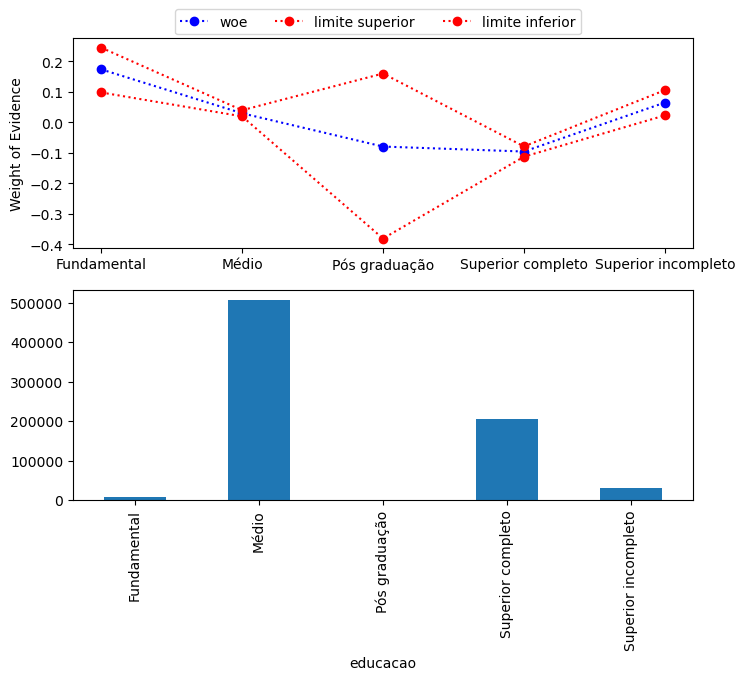

In [133]:
bi_discreta('educacao',df)

,qt_bom,qt_mau,mau,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,
Fundamental/Médio,386359,25991,0.063031,412350,0.000378,0.063773,0.062290,-2.699017,-2.686525,-2.711646,0.033674,0.046166,0.021045
Pós Graduação/Sup. Completo,154962,9129,0.055634,164091,0.000566,0.056743,0.054525,-2.831724,-2.810810,-2.853034,-0.099033,-0.078119,-0.120342
Superior incompleto,22036,1523,0.064646,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550


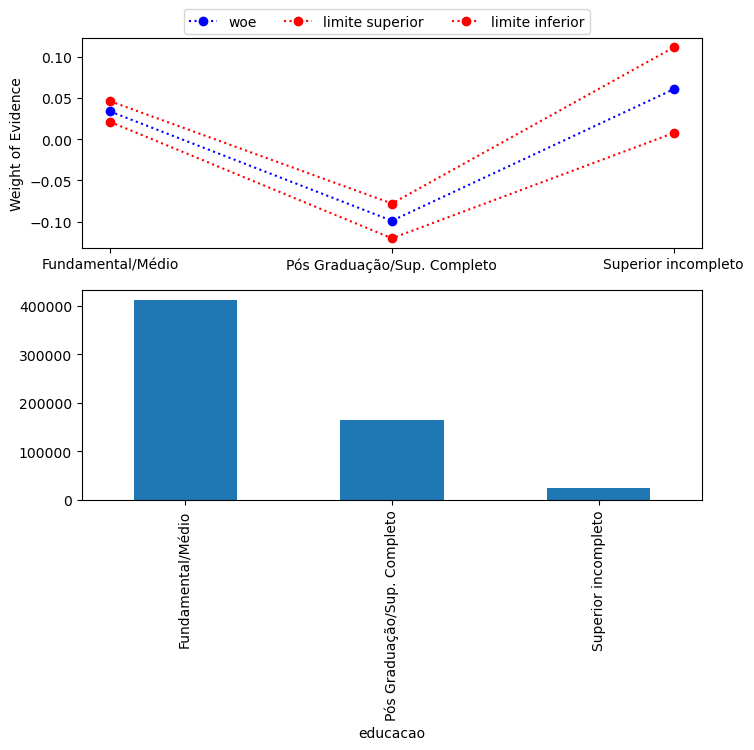

In [177]:
df_['educacao'] = df_['educacao'].replace({'Fundamental':'Fundamental/Médio',
                                           'Médio':'Fundamental/Médio',
                                           'Pós graduação':'Pós Graduação/Sup. Completo',
                                           'Superior completo':'Pós Graduação/Sup. Completo'})
bi_discreta('educacao',df_)

,qt_bom,qt_mau,mau,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,
Casado,395880,25269,0.060000,421149,0.000366,0.060717,0.059283,-2.751533,-2.738886,-2.764322,-0.018842,-0.006195,-0.031631
Separado,31994,2194,0.064175,34188,0.001325,0.066772,0.061577,-2.679822,-2.637360,-2.723916,0.052869,0.095331,0.008775
Solteiro,68585,4636,0.063315,73221,0.000900,0.065079,0.061551,-2.694222,-2.664858,-2.724359,0.038469,0.067833,0.008332
União,43048,3060,0.066366,46108,0.001159,0.068638,0.064094,-2.643901,-2.607801,-2.681168,0.088790,0.124890,0.051523
Viúvo,23850,1484,0.058577,25334,0.001475,0.061469,0.055686,-2.777043,-2.725779,-2.830738,-0.044352,0.006912,-0.098047


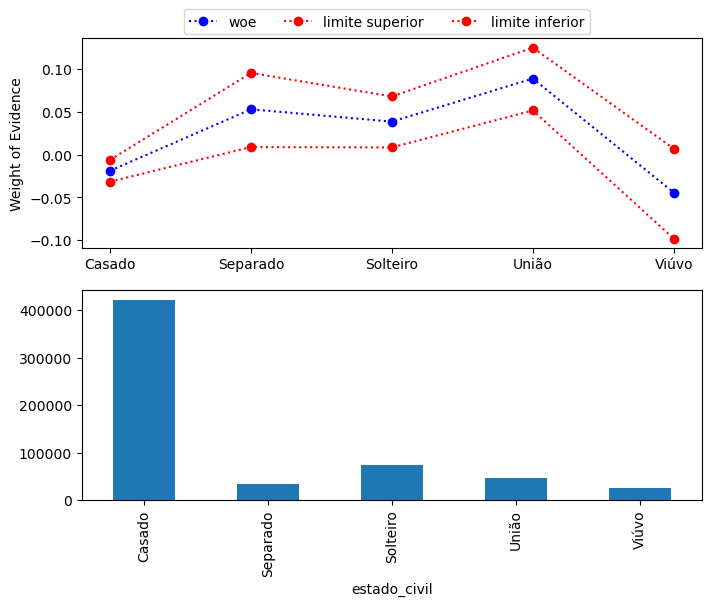

In [178]:
bi_discreta('estado_civil',df_)

,qt_bom,qt_mau,mau,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,
Aluguel,7666,596,0.072137,8262,0.002846,0.077717,0.066558,-2.554310,-2.473779,-2.640804,0.178382,0.258912,0.091887
Casa,506887,32449,0.060165,539336,0.000324,0.060799,0.059530,-2.748618,-2.737450,-2.759898,-0.015927,-0.004759,-0.027207
Com os pais,24733,1997,0.074710,26730,0.001608,0.077862,0.071558,-2.516492,-2.471755,-2.563000,0.216199,0.260936,0.169691
Comunitário,2449,185,0.070235,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.149612,0.290329,-0.010508
Estúdio,4071,225,0.052374,4296,0.003399,0.059038,0.045711,-2.895544,-2.768721,-3.038637,-0.162852,-0.036030,-0.305946
Governamental,17551,1191,0.063547,18742,0.001782,0.067040,0.060054,-2.690318,-2.633076,-2.750571,0.042373,0.099615,-0.017880


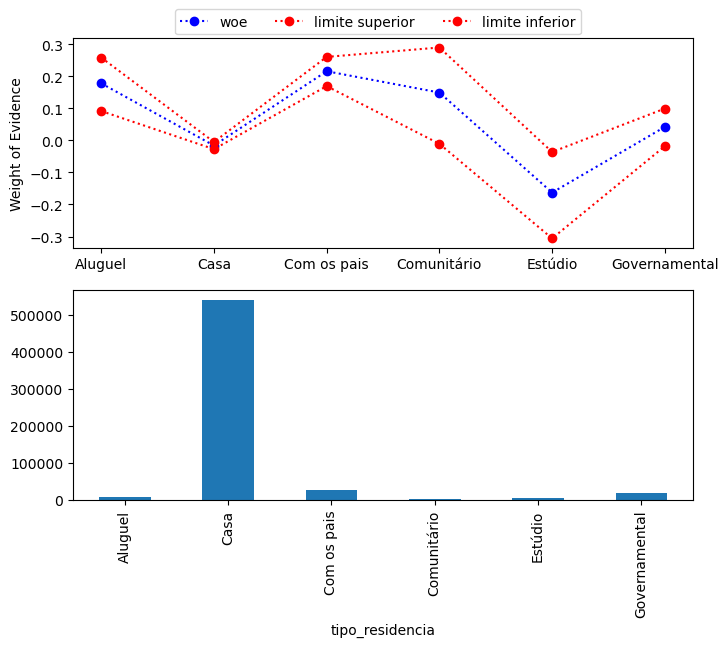

In [179]:
bi_discreta('tipo_residencia',df_)

,qt_bom,qt_mau,mau,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,
Casa,506887,32449,0.060165,539336,0.000324,0.060799,0.059530,-2.748618,-2.737450,-2.759898,-0.015927,-0.004759,-0.027207
Com pais/Aluguel/Comunitário/Estúdio/Governamental,56470,4194,0.069135,60664,0.001030,0.071154,0.067116,-2.600055,-2.569102,-2.631856,0.132637,0.163590,0.100835


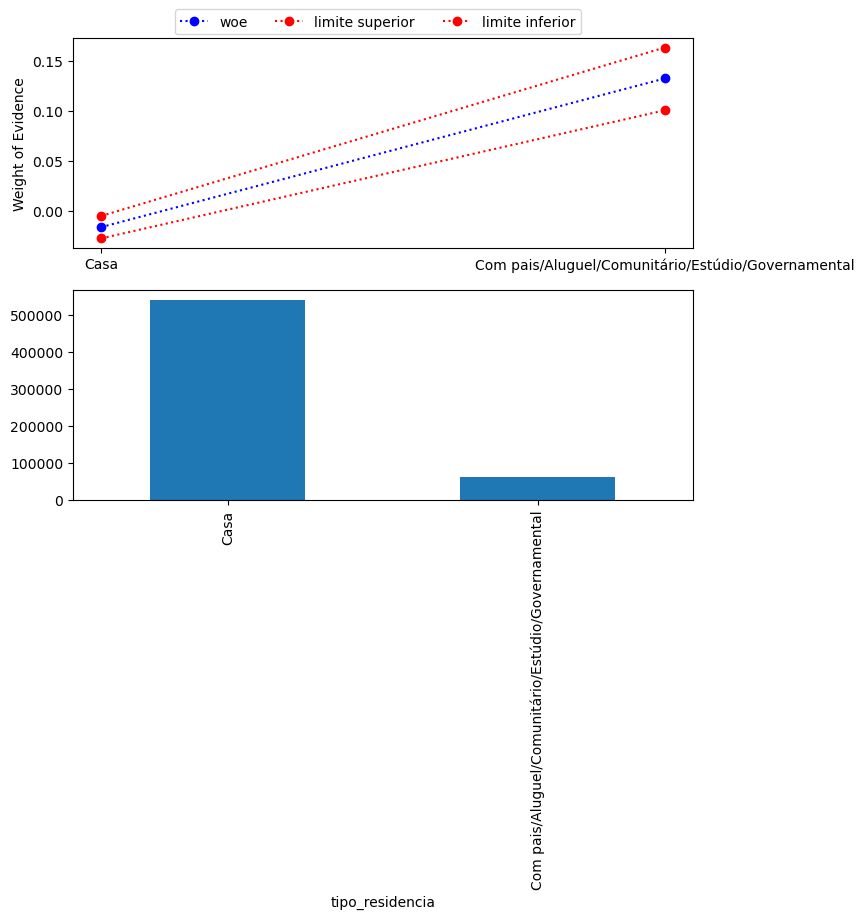

In [181]:
df_['tipo_residencia'] = df_['tipo_residencia'].replace({'Aluguel':'Com pais/Aluguel/Comunitário/Estúdio/Governamental',
                                           'Com os pais':'Com pais/Aluguel/Comunitário/Estúdio/Governamental',
                                           'Comunitário':'Com pais/Aluguel/Comunitário/Estúdio/Governamental',
                                           'Estúdio':'Com pais/Aluguel/Comunitário/Estúdio/Governamental',
                                           'Governamental':'Com pais/Aluguel/Comunitário/Estúdio/Governamental'})

bi_discreta('tipo_residencia',df_)


,qt_bom,qt_mau,mau,idade,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
idade,,,,,,,,,,,,,,
"(21.0, 33.0]",125124,10011,0.074081,29.352684,135135,0.000712,0.075478,0.072685,-2.525621,-2.505437,-2.546157,0.207070,0.227254,0.186534
"(33.0, 40.0]",115999,7703,0.062271,37.110572,123702,0.000687,0.063617,0.060924,-2.711972,-2.689140,-2.735269,0.020719,0.043551,-0.002578
"(40.0, 47.0]",108456,6470,0.056297,43.918548,114926,0.000680,0.057630,0.054964,-2.819168,-2.794360,-2.844535,-0.086477,-0.061669,-0.111844
"(47.0, 55.0]",104348,5612,0.051037,51.388459,109960,0.000664,0.052338,0.049736,-2.922824,-2.896285,-2.950012,-0.190133,-0.163594,-0.217320
"(55.0, 68.0]",109430,6847,0.058885,60.406039,116277,0.000690,0.060238,0.057532,-2.771474,-2.747317,-2.796158,-0.038783,-0.014626,-0.063467


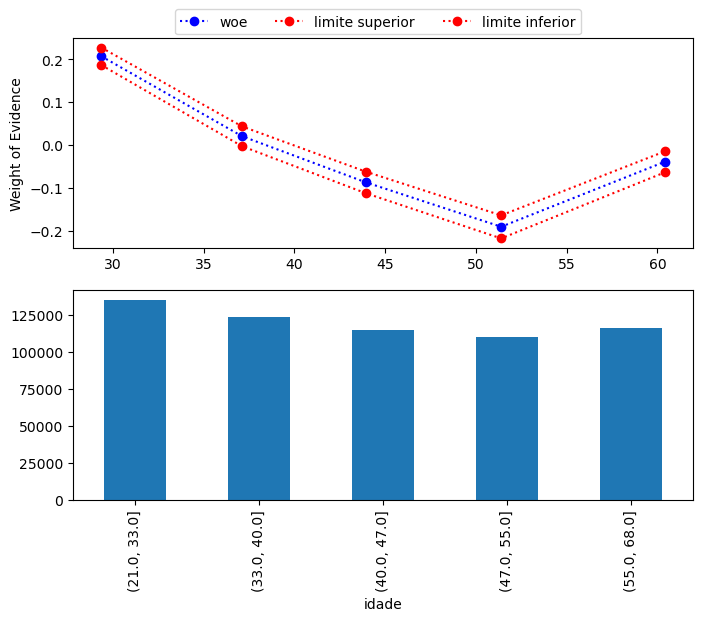

In [185]:
bi_continua('idade',5,df_)

,qt_bom,qt_mau,mau,tempo_emprego,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tempo_emprego,,,,,,,,,,,,,,
"(-1.0, 4.0]",135808,14582,0.096961,1.848354,150390,0.000763,0.098457,0.095466,-2.231454,-2.214491,-2.248653,0.501237,0.518201,0.484038
"(4.0, 7.0]",140037,9841,0.065660,5.444312,149878,0.000640,0.066914,0.064406,-2.655349,-2.635089,-2.675973,0.077342,0.097603,0.056718
"(7.0, 9.0]",140990,8742,0.058384,7.916555,149732,0.000606,0.059572,0.057197,-2.780550,-2.759151,-2.802362,-0.047859,-0.026459,-0.069671
"(9.0, 43.0]",146522,3478,0.023187,15.796907,150000,0.000389,0.023948,0.022425,-3.740718,-3.707619,-3.774896,-1.008027,-0.974928,-1.042205


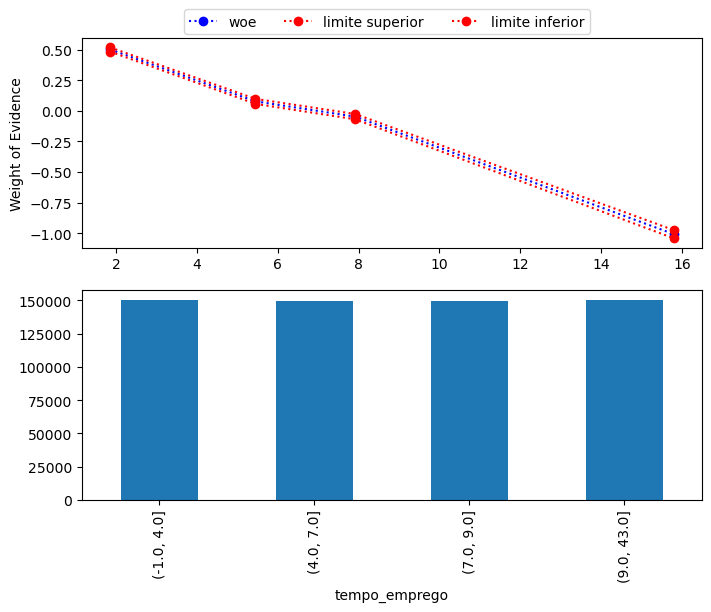

In [186]:
bi_continua('tempo_emprego',4,df_)

,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
"(0.0, 2.0]",408788,26050,0.059907,1.750121,434838,0.000360,0.060613,0.059202,-2.753179,-2.740723,-2.765773,-0.020488,-0.008032,-0.033082
"(2.0, 3.0]",97323,6803,0.065334,3.000000,104126,0.000766,0.066835,0.063833,-2.660672,-2.636351,-2.685518,0.072019,0.096340,0.047173
"(3.0, 15.0]",57246,3790,0.062095,4.159447,61036,0.000977,0.064009,0.060180,-2.714992,-2.682581,-2.748349,0.017699,0.050110,-0.015658


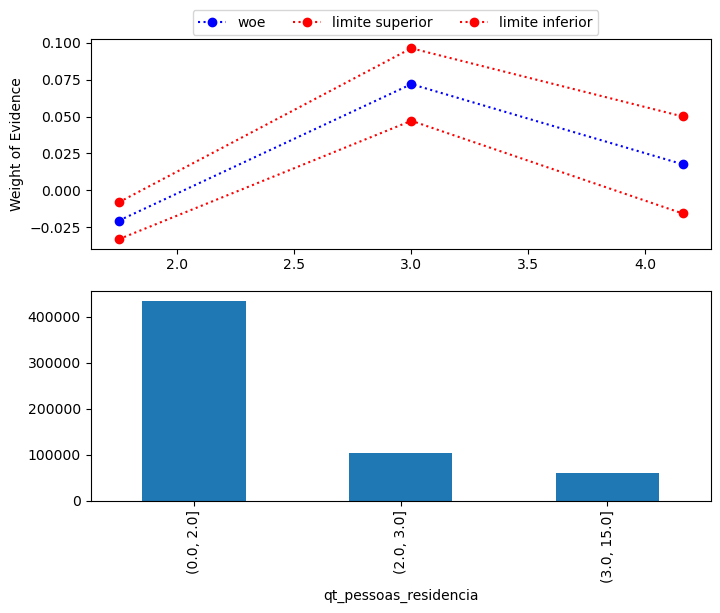

In [187]:
bi_continua('qt_pessoas_residencia',4,df_)

,qt_bom,qt_mau,mau,renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
renda,,,,,,,,,,,,,,
"(161.0, 6103.0]",174093,25913,0.129561,3424.773301,200006,0.000751,0.131033,0.128089,-1.904845,-1.891857,-1.917959,0.827846,0.840834,0.814732
"(6103.0, 16167.0]",191818,8186,0.040929,10284.192521,200004,0.000443,0.041797,0.040061,-3.154122,-3.132223,-3.176470,-0.421431,-0.399532,-0.443779
"(16167.0, 4083986.0]",197446,2544,0.012721,67962.658079,199990,0.000251,0.013212,0.012229,-4.351727,-4.313346,-4.391601,-1.619036,-1.580654,-1.658910


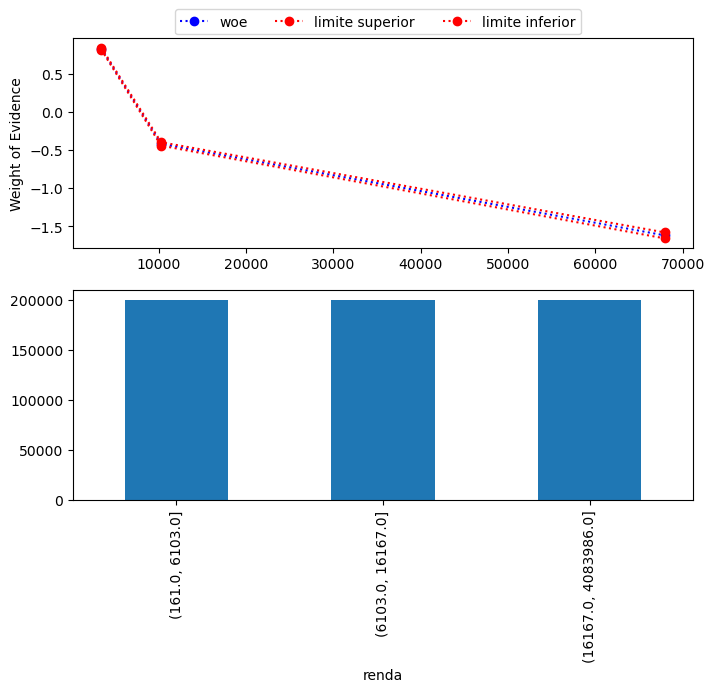

In [188]:
bi_continua('renda',3,df_)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [46]:
df_ = df_.drop(columns=['data_ref','index','bom'])

y = df_['mau']
X = pd.get_dummies(df_.drop(columns=['mau']))


In [47]:
reg = sm.Logit(y,X).fit()

reg.summary()


Optimization terminated successfully.
         Current function value: 0.208136
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                          Logit   Df Residuals:                   599974
Method:                           MLE   Df Model:                           25
Date:                Mon, 11 Sep 2023   Pseudo R-squ.:                 0.09469
Time:                        13:49:57   Log-Likelihood:            -1.2488e+05
converged:                       True   LL-Null:                   -1.3794e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
qtd_filhos                        0.1269      0.090      1.417      0.156      -0.049       0.302
idade                          9.477e-05      0.001      0.135      0.893      -0.001       0.001
tempo_emprego                    -0.0237      0.002    -13.133      0.000      -0.027      -0.020
qt_pessoas_residencia            -0.1237      0.089     -1.384      0.166      -0.299       0.051
renda                            -0.0001   1.09e-06    -93.637      0.000      -0.000   -9.95e-05
sexo_F                           -0.2461        nan        nan        nan         nan         nan
sexo_M                           -0.3724        nan        nan        nan         nan         nan
posse_de_veiculo_N               -0.3252   3.08e+05  -1.06e-06      1.000   -6.03e+05    6.03e+05
posse_de_veiculo_S               -0.2933   3.01e+05  -9.75e-07      1.000    -5.9e+05     5.9e+05
posse_de_imovel_N                -0.2664   3.65e+05   -7.3e-07      1.000   -7.15e+05    7.15e+05
posse_de_imovel_S                -0.3521   3.65e+05  -9.63e-07      1.000   -7.16e+05    7.16e+05
tipo_renda_Assalariado           -0.1238        nan        nan        nan         nan         nan
tipo_renda_Bolsista               0.0013        nan        nan        nan         nan         nan
tipo_renda_Empresário            -0.1769        nan        nan        nan         nan         nan
tipo_renda_Pensionista           -0.1635        nan        nan        nan         nan         nan
tipo_renda_Servidor público      -0.1556        nan        nan        nan         nan         nan
educacao_Fundamental             -0.0742   3.45e+04  -2.15e-06      1.000   -6.77e+04    6.77e+04
educacao_Médio                   -0.1047   7.11e+04  -1.47e-06      1.000   -1.39e+05    1.39e+05
educacao_Pós graduação           -0.1202   6.44e+04  -1.87e-06      1.000   -1.26e+05    1.26e+05
educacao_Superior completo       -0.1649   5.51e+04  -2.99e-06      1.000   -1.08e+05    1.08e+05
educacao_Superior incompleto     -0.1545   4.42e+04  -3.49e-06      1.000   -8.67e+04    8.67e+04
estado_civil_Casado              -0.0614        nan        nan        nan         nan         nan
estado_civil_Separado            -0.1470        nan        nan        nan         nan         nan
estado_civil_Solteiro            -0.1775        nan        nan        nan         nan         nan
estado_civil_União               -0.0139        nan        nan        nan         nan         nan
estado_civil_Viúvo               -0.2187        nan        nan        nan         nan         nan
tipo_residencia_Aluguel          -0.0325    1.7e+05  -1.91e-07      1.000   -3.34e+05    3.34e+05
tipo_residencia_Casa             -0.1217    1.7e+05  -7.14e-07      1.000   -3.34e+05    3.34e+05
tipo_residencia_Com os pais      -0.1068    1.7e+05  -6.27e-07      1.000   -3.34e+05    3.34e+05
tipo_residencia_Comunitário      -0.1727    1.7e+05  -1.01e-06      1.000   -3.34e+05    3.34e+05
tipo_re

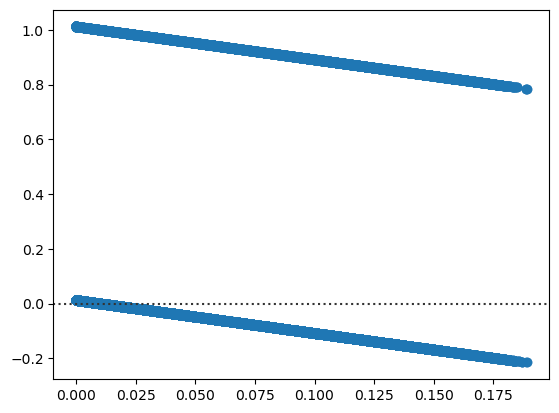

In [49]:
sns.residplot(x= reg.predict(), y= reg.resid_response);

In [50]:
y = df_['mau']
X = pd.get_dummies(df_[['tempo_emprego','renda','sexo']])

reg = sm.Logit(y,X).fit()

reg.summary()

Optimization terminated successfully.
         Current function value: 0.208241
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                          Logit   Df Residuals:                   599996
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Sep 2023   Pseudo R-squ.:                 0.09424
Time:                        13:50:54   Log-Likelihood:            -1.2494e+05
converged:                       True   LL-Null:                   -1.3794e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
tempo_emprego    -0.0239      0.002    -14.255      0.000      -0.027      -0.021
renda            -0.0001   1.08e-06    -95.230      0.000      -0.000      -0.000
sexo_F           -1.5649      0.011   -136.799      0.000      -1.587      -1.543
sexo_M           -1.6649      0.013   -123.802      0.000      -1.691      -1.639
=================================================================================
"""

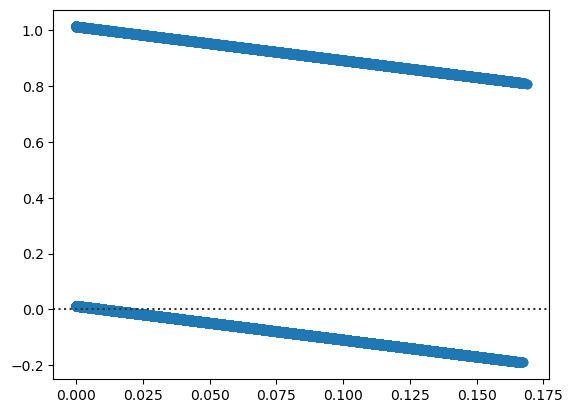

In [51]:
sns.residplot(x= reg.predict(), y= reg.resid_response);

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [52]:
X_pred = pd.get_dummies(smpl_oot[['tempo_emprego','renda','sexo']])
y_pred = reg.predict(X_pred)


In [62]:
metrics.accuracy_score(smpl_oot['mau'], y_pred.astype('int'))

0.8533333333333334